In [9]:
import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version reported by torch:", torch.version.cuda)
print("Device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Device 0:", torch.cuda.get_device_name(0))

Torch: 2.6.0+cu124
CUDA available: True
CUDA version reported by torch: 12.4
Device count: 1
Device 0: NVIDIA GeForce RTX 4070 Laptop GPU


In [10]:
from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    # Expects input images of size (3, 224, 224)
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(8)
        self.conv4 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(8 * 56 * 56, 32)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        # NOTE: no softmax here; CrossEntropyLoss does the softmax internally
        x = self.fc2(x)
        return x
    
class SimpleCNN2(nn.Module):
    # Expects input images of size (3, 224, 224)
    def __init__(self, num_classes=7):
        super(SimpleCNN2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(8)
        self.conv4 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8 * 56 * 56, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        # NOTE: no softmax here; CrossEntropyLoss does the softmax internally
        x = self.fc2(x)
        return x
    
def train_validate_cnn(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []

    model.to(device)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        train_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for i, (inputs, labels) in enumerate(train_iter):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            train_iter.set_postfix(loss=loss.item())

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        val_iter = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for inputs, labels in val_iter:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                val_iter.set_postfix(loss=loss.item())

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses


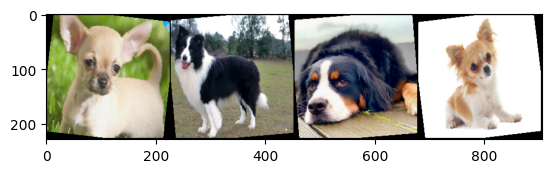

chihuahua border_collie bernese_mountain_dog chihuahua


In [11]:
# Test loader is dog-breed-images
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, Subset

image_path = "dog-breed-images/"


# TRAIN: random augmentations 
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15, hue=0.02),
    transforms.RandomRotation(degrees=10, fill=0),  # small rotation
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1), value='random')
])

base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

base_dataset = datasets.ImageFolder(image_path)  # no transform here

# 60/10/30 split (train/val/test)
n = len(base_dataset)
train_size = int(0.6 * n)
val_size   = int(0.1 * n)
test_size  = n - train_size - val_size  # ~30%
gen = torch.Generator().manual_seed(42)
train_subset, val_subset, test_subset = torch.utils.data.random_split(
    base_dataset, [train_size, val_size, test_size], generator=gen
)

# rewrap each split with its own transforms by creating new ImageFolder objects
train_dataset = Subset(datasets.ImageFolder(image_path, transform=train_tfms), train_subset.indices)
val_dataset   = Subset(datasets.ImageFolder(image_path, transform=base_transform),  val_subset.indices)
test_dataset  = Subset(datasets.ImageFolder(image_path, transform=base_transform),  test_subset.indices)

# DataLoaders
cuda = torch.cuda.is_available()
common_loader_kwargs = dict(num_workers=2, pin_memory=cuda, persistent_workers=(2 > 0))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  drop_last=True,  **common_loader_kwargs)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, drop_last=False, **common_loader_kwargs)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, drop_last=False, **common_loader_kwargs)

# If you want to print class names:
classes = datasets.ImageFolder(image_path).classes


# visualize a batch of images
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# show images
imshow(utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


def test_model(model, test_loader, device):
    # Test the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')
    return test_accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



Epoch 1/10: Train Loss: 2.0422, Val Loss: 1.9226


Epoch 2/10: Train Loss: 1.9350, Val Loss: 1.9069


Epoch 3/10: Train Loss: 1.8870, Val Loss: 1.8461


Epoch 4/10: Train Loss: 1.8629, Val Loss: 1.8145


Epoch 5/10: Train Loss: 1.8533, Val Loss: 1.7899


Epoch 6/10: Train Loss: 1.8543, Val Loss: 1.7755


Epoch 7/10: Train Loss: 1.8255, Val Loss: 1.8114


Epoch 8/10: Train Loss: 1.7834, Val Loss: 1.7538


Epoch 9/10: Train Loss: 1.7835, Val Loss: 1.7052


Epoch 10/10: Train Loss: 1.7714, Val Loss: 1.6993


Test Accuracy: 34.87%


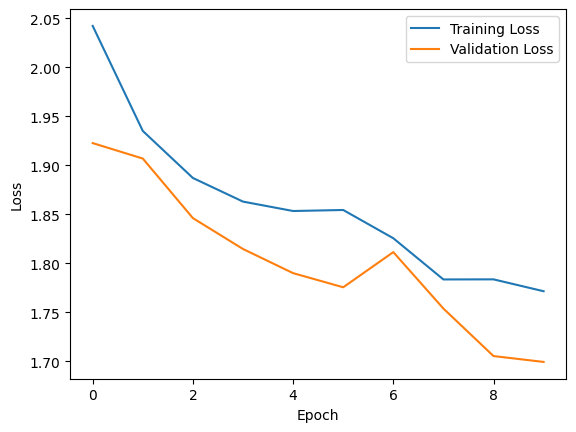

In [12]:

# Define criterion and optimizer
model = SimpleCNN(num_classes=len(train_loader.dataset.dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training loop
epochs = 10
train_losses, val_losses = train_validate_cnn(model, train_loader, val_loader, criterion, optimizer, epochs, device)

# Test the model
test_model(model, test_loader, device)

# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/10: Train Loss: 1.9834, Val Loss: 1.9277


Epoch 2/10: Train Loss: 1.8630, Val Loss: 1.9257


Epoch 3/10: Train Loss: 1.8174, Val Loss: 1.8726


Epoch 4/10: Train Loss: 1.7104, Val Loss: 1.7607


Epoch 5/10: Train Loss: 1.6152, Val Loss: 1.7443


Epoch 6/10: Train Loss: 1.5670, Val Loss: 1.8048


Epoch 7/10: Train Loss: 1.4898, Val Loss: 1.5915


Epoch 8/10: Train Loss: 1.4933, Val Loss: 1.5506


Epoch 9/10: Train Loss: 1.4401, Val Loss: 1.6376


Epoch 10/10: Train Loss: 1.4271, Val Loss: 1.6225


Test Accuracy: 31.28%


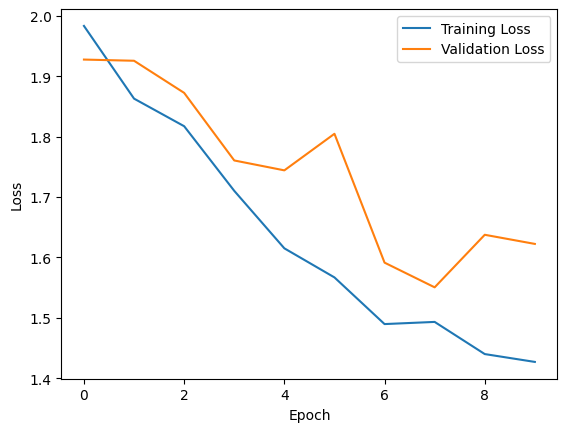

In [13]:
# Same as above, but without dropout

# Define criterion and optimizer
model = SimpleCNN2(num_classes=len(train_loader.dataset.dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training loop
epochs = 10
train_losses, val_losses = train_validate_cnn(model, train_loader, val_loader, criterion, optimizer, epochs, device)

# Test the model
test_accuracy = test_model(model, test_loader, device)

# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



## Part 2 Task I
### Inspection of Datasets:

- Stanford Dogs Dataset: Typically features higher-resolution images, varied backgrounds, and dogs in natural settings. Images may have more challenging backgrounds and diverse poses.
- Dog Breed Images Dataset: May contain more standardized images, often with simpler backgrounds or studio-like settings. The annotation style and cropping may differ.

Briefly document any consistent differences you notice, as these can impact model training and generalization.

## Task 3: ResNet training
a) In this task, we use the ResNet-18 model for the classification of the images in the DBI dataset. To do so, use the ResNet-18 model from PyTorch, modify the input/output layers to match your dataset, and train the model from scratch; i.e., do not use the pre- trained ResNet. Plot the training and validationaccuracy and report the final test results, and compare those with the results of your CNN model.

b) Run the trained model on the entire SDD dataset and report the accuracy. Compare the accuracy obtained on the (test set of) DBI, vs. the accuracy obtained on the SDD. Which is higher? Why do you think that might be? Explain very briefly, in one or two sentences.

c:\Users\Jagri\miniconda3\envs\compvision\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jagri\miniconda3\envs\compvision\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10: Train Loss: 2.2183, Val Loss: 2.6339


Epoch 2/10: Train Loss: 1.7793, Val Loss: 2.1607


Epoch 3/10: Train Loss: 1.6241, Val Loss: 1.9217


Epoch 4/10: Train Loss: 1.4967, Val Loss: 2.1280


Epoch 5/10: Train Loss: 1.4675, Val Loss: 2.1179


Epoch 6/10: Train Loss: 1.4334, Val Loss: 3.2314


Epoch 7/10: Train Loss: 1.3584, Val Loss: 1.4856


Epoch 8/10: Train Loss: 1.2727, Val Loss: 4.2022


Epoch 9/10: Train Loss: 1.1934, Val Loss: 2.7157


Epoch 10/10: Train Loss: 1.1276, Val Loss: 1.5077


Test Accuracy: 42.56%


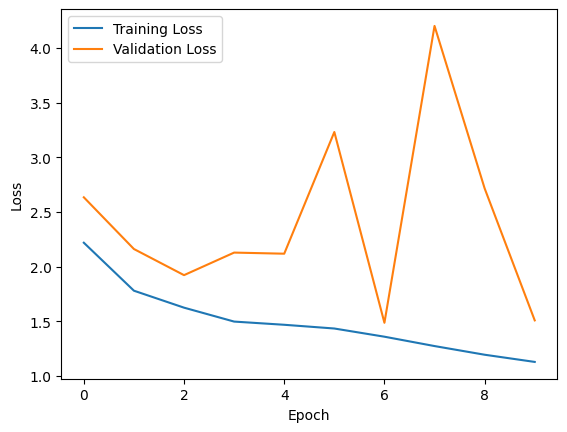

In [14]:
import torchvision.models as models

# Load an untrained ResNet-18 model
resnet18_untrained = models.resnet18(pretrained=False)

# modify the final layer to match the number of classes in your dataset
num_ftrs = resnet18_untrained.fc.in_features
resnet18_untrained.fc = nn.Linear(num_ftrs, len(train_loader.dataset.dataset.classes))

resnet_model = resnet18_untrained.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001, weight_decay=1e-5)
epochs = 10
train_losses, val_losses = train_validate_cnn(resnet_model, train_loader, val_loader, criterion, optimizer, epochs, device)
test_accuracy = test_model(resnet_model, test_loader, device)

# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# Run the trained ResNet model on the entirety of the Stanford Dog Dataset (SDD)

sdd_path = "stanford-dogs-dataset/images/"
sdd_dataset = datasets.ImageFolder(sdd_path, transform=base_transform)
sdd_loader = DataLoader(sdd_dataset, batch_size=32, shuffle=False, drop_last=False, **common_loader_kwargs)

test_accuracy = test_model(resnet_model, sdd_loader, device)

Test Accuracy: 30.17%


# TODO: 
Compare the accuracy obtained on the (test set of) DBI, vs. the accuracy obtained on the SDD. Which is higher? Why do you think that might be? Explain very briefly, in one or two sentences.

# TODO: Task 4: Fine-Tuning on DBI

Fine tune a number of different pre-trained models on the DBI.

In [18]:
# load pretrained models
from torchvision import models 

resnet18 = models.resnet18(pretrained=True) # resnet18
resnet34 = models.resnet34(pretrained=True) #resnet34
resnext50 = models.resnext50_32x4d(pretrained=True) #resneXt 50
swintrans = models.swin_t(pretrained=True) #swinTransformer tiny

#fifth model of my choosing: vgg16 
vit = models.vit_b_32(pretrained=True)

# replace final layer for output classes

# modify the final layer to match the number of classes in your dataset

# ResNet18
num_ftrs = resnet18_untrained.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, len(train_loader.dataset.dataset.classes))

# ResNet34
num_ftrs_34 = resnet34.fc.in_features
resnet34.fc = nn.Linear(num_ftrs_34, len(train_loader.dataset.dataset.classes))

# ResNeXt50
num_ftrs_next = resnext50.fc.in_features
resnext50.fc = nn.Linear(num_ftrs_next, len(train_loader.dataset.dataset.classes))

# Swin Transformer Tiny
num_ftrs_swin = swintrans.head.in_features
swintrans.head = nn.Linear(num_ftrs_swin, len(train_loader.dataset.dataset.classes))

# ViT 32
num_ftrs_vit = vit.heads.head.in_features
vit.heads.head = nn.Linear(num_ftrs_vit, len(train_loader.dataset.dataset.classes))

models_to_train = [
    ("ResNet18", resnet18),
    ("ResNet34", resnet34),
    ("ResNeXt50", resnext50),
    ("SwinTransformerTiny", swintrans),
    ("ViT", vit)
]

results = {}


for name, model in models_to_train:
    print(f"\nTraining {name}...")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    epochs = 10
    train_losses, val_losses = train_validate_cnn(model, train_loader, val_loader, criterion, optimizer, epochs, device)

    dbi_acc = test_model(model, test_loader, device)
    sdd_acc = test_model(model, sdd_loader, device)

    results[name] = {"DBI": dbi_acc, "SDD": sdd_acc}

print("\nSummary of Accuracies:")
for name, accs in results.items():
    print(f"{name}: DBI={accs['DBI']:.2f}%, SDD={accs['SDD']:.2f}%")



c:\Users\Jagri\miniconda3\envs\compvision\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jagri\miniconda3\envs\compvision\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Jagri\miniconda3\envs\compvision\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weigh


Training ResNet18...


Epoch 1/10: Train Loss: 0.8365, Val Loss: 5.0081


Epoch 2/10: Train Loss: 0.5346, Val Loss: 9.1399


Epoch 3/10: Train Loss: 0.4246, Val Loss: 2.3452


Epoch 4/10: Train Loss: 0.2944, Val Loss: 1.0406


Epoch 5/10: Train Loss: 0.1828, Val Loss: 0.7399


Epoch 6/10: Train Loss: 0.2215, Val Loss: 1.3372


Epoch 7/10: Train Loss: 0.1470, Val Loss: 1.4949


Epoch 8/10: Train Loss: 0.1479, Val Loss: 2.0347


Epoch 9/10: Train Loss: 0.0838, Val Loss: 0.8806


Epoch 10/10: Train Loss: 0.1325, Val Loss: 1.3663


Test Accuracy: 67.18%


Test Accuracy: 48.01%

Training ResNet34...


Epoch 1/10: Train Loss: 1.0952, Val Loss: 16.8818


Epoch 2/10: Train Loss: 0.6092, Val Loss: 2.2770


Epoch 3/10: Train Loss: 0.4939, Val Loss: 1.5414


Epoch 4/10: Train Loss: 0.3726, Val Loss: 2.4814


Epoch 5/10: Train Loss: 0.2785, Val Loss: 2.2109


Epoch 6/10: Train Loss: 0.3067, Val Loss: 1.0023


Epoch 7/10: Train Loss: 0.2926, Val Loss: 2.0673


Epoch 8/10: Train Loss: 0.3511, Val Loss: 1.2831


Epoch 9/10: Train Loss: 0.4107, Val Loss: 0.9127


Epoch 10/10: Train Loss: 0.2759, Val Loss: 0.8741


Test Accuracy: 81.03%


Test Accuracy: 62.94%

Training ResNeXt50...


Epoch 1/10: Train Loss: 0.9299, Val Loss: 8.3476


Epoch 2/10: Train Loss: 0.7213, Val Loss: 1.9889


Epoch 3/10: Train Loss: 0.4831, Val Loss: 2.0423


Epoch 4/10: Train Loss: 0.3497, Val Loss: 1.4120


Epoch 5/10: Train Loss: 0.3303, Val Loss: 0.8725


Epoch 6/10: Train Loss: 0.1944, Val Loss: 0.9642


Epoch 7/10: Train Loss: 0.1618, Val Loss: 0.5942


Epoch 8/10: Train Loss: 0.2236, Val Loss: 0.5655


Epoch 9/10: Train Loss: 0.2064, Val Loss: 3.0855


Epoch 10/10: Train Loss: 0.1986, Val Loss: 1.1218


Test Accuracy: 71.28%


Test Accuracy: 55.47%

Training SwinTransformerTiny...


Epoch 1/10: Train Loss: 2.1837, Val Loss: 2.0507


Epoch 2/10: Train Loss: 2.0278, Val Loss: 1.9250


Epoch 3/10: Train Loss: 2.0401, Val Loss: 2.0000


Epoch 4/10: Train Loss: 1.9909, Val Loss: 1.9490


Epoch 5/10: Train Loss: 2.0313, Val Loss: 1.9450


Epoch 6/10: Train Loss: 2.0045, Val Loss: 1.9637


Epoch 7/10: Train Loss: 1.9828, Val Loss: 1.9666


Epoch 8/10: Train Loss: 1.9775, Val Loss: 1.9478


Epoch 9/10: Train Loss: 1.9894, Val Loss: 1.9968


Epoch 10/10: Train Loss: 1.9848, Val Loss: 1.9504


Test Accuracy: 15.38%


Test Accuracy: 17.68%

Training ViT...


Epoch 1/10: Train Loss: 2.5752, Val Loss: 2.0964


Epoch 2/10: Train Loss: 2.0116, Val Loss: 1.9559


Epoch 3/10: Train Loss: 2.0139, Val Loss: 1.9789


Epoch 4/10: Train Loss: 1.9759, Val Loss: 1.9064


Epoch 5/10: Train Loss: 1.9608, Val Loss: 1.9732


Epoch 6/10: Train Loss: 1.9585, Val Loss: 1.9448


Epoch 7/10: Train Loss: 1.9606, Val Loss: 1.9041


Epoch 8/10: Train Loss: 1.9657, Val Loss: 1.8617


Epoch 9/10: Train Loss: 1.9350, Val Loss: 1.9256


Epoch 10/10: Train Loss: 1.9291, Val Loss: 1.8824


Test Accuracy: 15.90%


Test Accuracy: 19.63%

Summary of Accuracies:
ResNet18: DBI=67.18%, SDD=48.01%
ResNet34: DBI=81.03%, SDD=62.94%
ResNeXt50: DBI=71.28%, SDD=55.47%
SwinTransformerTiny: DBI=15.38%, SDD=17.68%
ViT: DBI=15.90%, SDD=19.63%


Summary of Accuracies:

ResNet18: DBI=67.18%, SDD=48.01%

ResNet34: DBI=81.03%, SDD=62.94%

ResNeXt50: DBI=71.28%, SDD=55.47%

SwinTransformerTiny: DBI=15.38%, SDD=17.68%

ViT: DBI=15.90%, SDD=19.63%



# TODO: Task 5: Dataset Detection
Train a model that will binary classify which dataset an image belongs to.

# TODO: Task 6: How to improve performance on SDD?
If our goal were to have good performance on the SDD dataset, briefly discuss how to work towards this goal in each of the following cases: (you don’t need to implement these, just briefly discuss each case in 2-3 sentences)

# TODO: Task 7: Discussion

Briefly discuss how some of the issues that were examined in this exercise can have implications in real application, e.g. as related to bias or performance. For example, consider the case where available training datasets are collected in one setting (e.g. a university) and the goal is to deploy trained models in another setting (e.g. a retirement home).

# Task 8: Tracking Comparison
Use a face detection model (such as MediaPipe Face Detection, OpenCV’s DNN face detector, or MTCNN) to detect the face in the first frame of the video.

Initialize three different face trackers with the detected bounding box:

• CSRT Tracker or KCF Tracker (both have OpenCV implementation)

• Two other trackers: research and select two additional trackers of your choosing. 

Try to choose good new models, e.g. by looking up leaderboards. Note that we are looking for tracking models, not face detection models.
If you wish, instead of CSRT or KCF you can also use another tracker of your choosing.

## Performance Analysis:
• Track the face through all frames of the video using each of the three trackers.

• For ground truth comparison, run your face detection model on every 5th frame to establish reference bounding boxes. For this assignment, we’re going to assume that the face detection model is perfect and gives us the ground truth location of the face.

• Calculate the intersection over union (IoU) between each tracker’s predicted bounding box and the ground truth for these reference frames.

• (5 marks) Create a comparison plot showing IoU over time for all three trackers on the same graph, with different colors/line styles for each tracker.

In [ ]:
import cv2 
import numpy as np

# initialize cv2 neural network face detector
net = cv2.dnn.readNetFromCaffe("models/deploy.prototxt.txt", "models/res10_300x300_ssd_iter_140000.caffemodel")

# create function to detect faces in an image
def detect_faces(image):
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
        (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()
    faces = []
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            faces.append((startX, startY, endX, endY))
    return faces

def to_xywh(box_xyxy):
    x1, y1, x2, y2 = box_xyxy
    return (int(x1), int(y1), int(x2 - x1), int(y2 - y1))

# break video into array of frames 
def video_to_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

frames = video_to_frames("TheOffice.mp4") # let's try to use a different video (of my own face) to reduce track seduction

# get first frame and detect face
first_face_bbox = to_xywh(detect_faces(frames[0])[0])
gt = [] # ground truth boxes 
gt.append([0, first_face_bbox]) # frame number, (x, y, w, h)    

tracker = cv2.TrackerCSRT_create() # Initialize the CSRT tracker
tracker.init(frames[0], first_face_bbox) # tracker wants (x, y, w, h)

goturn_tracker = cv2.TrackerGOTURN.create() # initialize the GOTURN tracker
goturn_tracker.init(frames[0], first_face_bbox)

mosse_tracker = cv2.legacy.TrackerMOSSE_create()
mosse_tracker.init(frames[0], first_face_bbox)

tracks = {"CRST": [],
          "GOTURN": [],
          "MOSSE": []}

# loop through all frames and track the face
for i, frame in enumerate(frames):
    # Update the CRST tracker and get the new bounding box
    success, bbox = tracker.update(frame)
    goturn_success, goturn_bbox = goturn_tracker.update(frame)
    mosse_success, mosse_bbox = mosse_tracker.update(frame)

    if success:
        # Draw the bounding box on the frame
        x, y, w, h = [int(v) for v in bbox]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, "CRST Tracking", (100, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)
        tracks["CRST"].append([i, (x, y, w, h)]) # store frame number and bbox
    else:
        # Tracking failed
        cv2.putText(frame, "CRST Tracking failed!", (100, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)

    
    if goturn_success:
        x, y, w, h = [int(v) for v in goturn_bbox]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(frame, "GOTURN Tracking", (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0), 2)
        tracks["GOTURN"].append([i, (x, y, w, h)]) # store frame number and bbox
    else:
        cv2.putText(frame, "GOTURN Tracking failed!", (100, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)


    if mosse_success:
        x, y, w, h = [int(v) for v in mosse_bbox]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 2)
        cv2.putText(frame, "MOSSE Tracking", (100, 110), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 255), 2)
        tracks["MOSSE"].append([i, (x, y, w, h)]) # store frame number and bbox

    # detect face for every fifth frame as ground truth
    if i % 5 == 0 and i != 0:
        faces = detect_faces(frame)
        if len(faces) > 0:
            x, y, w, h = to_xywh(faces[0])
            gt.append([i, to_xywh(faces[0])]) # store frame number and bbox
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 2) # red box for ground truth
            cv2.putText(frame, "Ground Truth", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            

    # Display the frame
    cv2.imshow("Tracking", frame)
    # Exit on 'q' press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    # press q to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()

print("Ground Truth:", gt)
print("Tracks:", tracks)

tracks['ground_truth'] = gt

# save tracks dict as json
import json
with open("tracks.json", "w") as f:
    json.dump(tracks, f)


Ground Truth: [[0, (392, 60, 77, 117)], [5, (391, 58, 82, 120)], [10, (392, 57, 82, 117)], [15, (390, 57, 87, 118)], [20, (391, 61, 81, 117)], [25, (392, 68, 88, 122)], [30, (391, 75, 85, 114)], [35, (390, 65, 82, 117)], [40, (386, 67, 79, 115)], [50, (413, 70, 82, 115)], [55, (445, 72, 70, 124)], [60, (445, 94, 78, 108)], [65, (429, 94, 80, 120)], [70, (393, 93, 76, 106)], [75, (357, 71, 81, 116)], [80, (367, 86, 76, 118)], [85, (410, 79, 71, 116)], [205, (2, 114, 104, 101)], [270, (456, 215, 36, 44)], [275, (449, 216, 43, 47)], [280, (447, 203, 46, 46)], [285, (456, 206, 45, 49)]]
Tracks: {'CRST': [[0, (392, 60, 77, 117)], [1, (392, 60, 77, 117)], [2, (392, 60, 77, 117)], [3, (392, 59, 77, 117)], [4, (393, 61, 75, 115)], [5, (392, 59, 77, 117)], [6, (392, 59, 77, 117)], [7, (392, 59, 77, 117)], [8, (393, 60, 75, 115)], [9, (392, 58, 77, 117)], [10, (393, 60, 75, 115)], [11, (392, 58, 77, 117)], [12, (392, 58, 77, 117)], [13, (392, 58, 77, 117)], [14, (392, 58, 77, 117)], [15, (392, 5

Average IoU for CRST: 0.6877
Average IoU for GOTURN: 0.4648
Average IoU for MOSSE: 0.6894


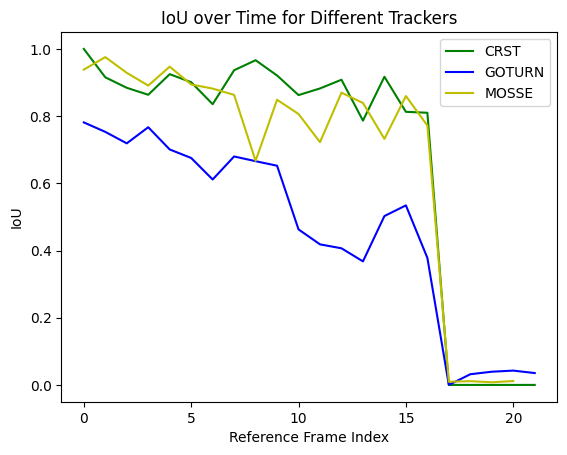

In [ ]:
# Calculate the intersection over union (IoU) between each tracker’s predicted bounding box and the ground truth for these reference frames.
ious = {"CRST": [], "GOTURN": [], "MOSSE": []}
def bb_intersection_over_union(boxA, boxB):
    # boxes are stored as (x,y,w,h)
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

for method in ["CRST", "GOTURN", "MOSSE"]:
    for gt_frame, gt_box in gt:
        # find the corresponding box in tracks
        pred_boxes = [box for frame, box in tracks[method] if frame == gt_frame]
        if len(pred_boxes) > 0:
            pred_box = pred_boxes[0]
            iou = bb_intersection_over_union(gt_box, pred_box)
            ious[method].append(iou)
    if len(ious[method]) > 0:
        avg_iou = sum(ious[method]) / len(ious[method])
    else:
        avg_iou = 0
    print(f"Average IoU for {method}: {avg_iou:.4f}")

# Create a comparison plot showing IoU over time for all three trackers on the same graph, with different colors/line styles for each tracker.
import matplotlib.pyplot as plt
for method, color in zip(["CRST", "GOTURN", "MOSSE"], ['g', 'b', 'y']):
    plt.plot(range(len(ious[method])), ious[method], label=method, color=color)

plt.xlabel("Reference Frame Index")
plt.ylabel("IoU")
plt.title("IoU over Time for Different Trackers")
plt.legend()
plt.savefig("iou_comparison.png")# save plot as png


plt.show()



# Qualitative Analysis 
Select two frames, one where the tracking should be very easy, and one where it should be more difficult.